<a href="https://colab.research.google.com/github/ali1810/Solubility_Prediction/blob/main/Solubility_Fingerprints_new_Nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Installation of condacolab to install rdkit ....
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:42
🔁 Restarting kernel...


In [57]:
### Installing RDKIT 

#!mamba install -c conda-forge rdkit

In [1]:
import pandas as pd 
import keras as k
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Input, Dense
from keras.layers.core import Dense
#from keras.optimizer import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras import losses
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Fingerprints import FingerprintMols
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from numpy import argmax
from numpy import ndarray
import tensorflow as tf
import math
import re
import string
from collections import OrderedDict
import pandas as pd
import csv
from collections import defaultdict


In [2]:
data=pd.read_csv('/content/drive/MyDrive/KIT/delaney.csv')
#data=pd.read_csv('/content/drive/MyDrive/KIT/acetone_solubility_data.csv')

#data=pd.read_csv('/content/drive/MyDrive/KIT/curated-solubility-dataset_new.csv')
#data=pd.read_csv('/content/drive/MyDrive/KIT/ESOL_delaney-processed.csv')
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [56]:
#data.isnull()

In [4]:
data["smiles_length"]= data["SMILES"].apply(len)

In [5]:
data  = data[data['smiles_length'] < 100]
print(len(data))

1144


In [6]:
smiles_array=data.SMILES

In [9]:
solubility_array= data.iloc[:,2]
#print(solubility_array)

In [ ]:
#data.isnull()

In [ ]:
#print(len(df6))


In [ ]:
data = data.dropna()

In [10]:
print(len(smiles_array))
print(len(solubility_array))

1144
1144


In [11]:
#Turning SMILES into Explicit Bit Vectors (RDKit prefered format)
mols = [Chem.rdmolfiles.MolFromSmiles(SMILES_string) for SMILES_string in smiles_array]


#Convert training molecules into training fingerprints
bi = {}
fingerprints = [Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo= bi, nBits=512) for m in mols]



In [12]:
#Convert training fingerprints into binary, and put all training binaries into arrays
import numpy as np 

fingerprints_array = []
for fingerprint in fingerprints:
        array = np.zeros((1,), dtype= int)
        DataStructs.ConvertToNumpyArray(fingerprint, array)
        fingerprints_array.append(array)

In [13]:
fingerprints_array =np.array(fingerprints_array)
solubility_array =np.array(solubility_array)

In [14]:
print(len(fingerprints_array))
print(len(solubility_array))
print(fingerprints_array.shape)
print(solubility_array.shape)

1144
1144
(1144, 512)
(1144,)


In [15]:
### Write a function to calculate these values....

def getAromaticProportion(m):
    aromatic_list = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aromatic = 0
    for i in aromatic_list:
        if i:
            aromatic += 1
    heavy_atom = Lipinski.HeavyAtomCount(m)
    return aromatic / heavy_atom


def generate(smiles):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:

        desc_MolLogP = Crippen.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Lipinski.NumRotatableBonds(mol)
        desc_AromaticProportion = getAromaticProportion(mol)
        desc_Ringcount        =   Descriptors.RingCount(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_Hdonrs=Lipinski.NumHDonors(mol)
        desc_SaturatedRings = Lipinski.NumSaturatedRings(mol)   
        desc_AliphaticRings = Lipinski.NumAliphaticRings(mol) 
        desc_HAcceptors =     Lipinski.NumHAcceptors(mol)
        desc_Heteroatoms =    Lipinski.NumHeteroatoms(mol)
        #desc_Max_Partial_Charge =  Descriptors.MaxPartialCharge(mol)
        #desc_FP_density =  Descriptors.FpDensityMorgan1(mol)
        #desc_num_valence_electrons = Descriptors.NumValenceElectrons(mol)
        #desc_molMR=Descriptors.MolMR(mol)
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion,desc_Ringcount,desc_TPSA,desc_Hdonrs,desc_SaturatedRings,desc_AliphaticRings,
                        desc_HAcceptors,desc_Heteroatoms])
                        #,desc_Max_Partial_Charge,desc_FP_density,desc_num_valence_electrons])

        if i == 0:
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames = ["MolLogP", "MolWt", "NumRotatableBonds", "AromaticProportion","Ring_Count","TPSA","H_donors",
                   "Saturated_Rings","AliphaticRings","H_Acceptors","Heteroatoms"]
                   #,"Max_Partial_Charge","FP_density","valence_electrons"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors


In [16]:
import numpy as np
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen

In [17]:
descriptors =generate(data.SMILES)
print(descriptors)

      MolLogP    MolWt  ...  H_Acceptors  Heteroatoms
0     2.59540  167.850  ...          0.0          4.0
1     2.37650  133.405  ...          0.0          3.0
2     2.59380  167.850  ...          0.0          4.0
3     2.02890  133.405  ...          0.0          3.0
4     2.91890  187.375  ...          0.0          6.0
...       ...      ...  ...          ...          ...
1139  1.98820  287.343  ...          6.0          8.0
1140  3.42130  286.114  ...          3.0          6.0
1141  3.60960  308.333  ...          4.0          4.0
1142  2.56214  354.815  ...          4.0          8.0
1143  2.02164  179.219  ...          2.0          3.0

[1144 rows x 11 columns]


In [18]:
import numpy as np 
df1=np.array(descriptors)

#df_new=fingerprints_array.join(df1)

In [19]:
df1.shape
#fingerprints_array.shape

(1144, 11)

In [20]:
### Adding two numpy array with column wise .....to add 11 descriptors along with finger prints 
df_new = np.append(fingerprints_array, df1, axis = 1)
df_new.shape

(1144, 523)

In [21]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_new, solubility_array, test_size = 0.2)

In [ ]:
#print(X_train[0])

In [34]:
### Making data as standard Scaler ....
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [24]:
#### Applying different Machine learning and Deep learning techique to know which works best ....
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
model_svr=SVR(kernel='rbf')
model_svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
model_rf = RandomForestRegressor(n_estimators = 15000, random_state = 0)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [35]:
Y_pred_test_rf = model_rf.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [36]:
Y_pred_train_rf = model_rf.predict(X_train)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [37]:
from sklearn.metrics import r2_score
r2_score(y_train, Y_pred_train_rf)

0.9760891036432956

In [38]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_rf)

0.9871392261914016

In [39]:
model_xgr = XGBRegressor(n_estimators = 15500, random_state = 0)
model_xgr.fit(X_train, y_train)


[10:15:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=15500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [40]:
Y_pred_train_xg = model_xgr.predict(X_train)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [41]:
from sklearn.metrics import r2_score
r2_score(y_train, Y_pred_train_xg)

0.9999979138009931

In [42]:
Y_pred_test_xg = model_xgr.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [43]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_xg)

0.9771805274376312

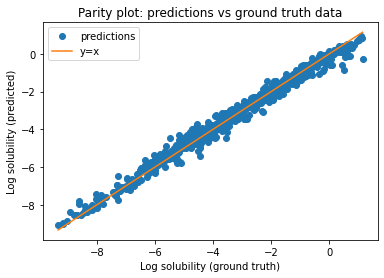

In [ ]:
import matplotlib.pyplot as plt
preds = model_rf.predict(X_train)
x_y_line = np.linspace(min(y_train.flatten()), max(y_train.flatten()), 500)
plt.plot(y_train.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y=x')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [45]:
import pickle
#### Save the model :::::
#filename = 'finalized_model.rf'
#pickle.dump(model_rf, open('/content/drive/MyDrive/KIT/solubility_model_98.71_523_delney.pkl', 'wb'))
pickle.dump(model_xgr, open('/content/drive/MyDrive/KIT/solubility_model_97.71_523_delney.pkl', 'wb'))

#model_rf.save("/content/drive/MyDrive/KIT/solubility_model_96.61_523_delney.pkl")

In [46]:
# some time later...
import pickle 
# load the model from disk
#loaded_model = pickle.load(open('/content/drive/MyDrive/KIT/solubility_model_97.55_523_delney.pkl', 'rb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/KIT/solubility_model_98.71_523_delney.pkl', 'rb'))
Y_pred_test_rf = loaded_model.predict(X_test)
result = r2_score(y_test, Y_pred_test_rf)
print(result)

0.9871392261914016


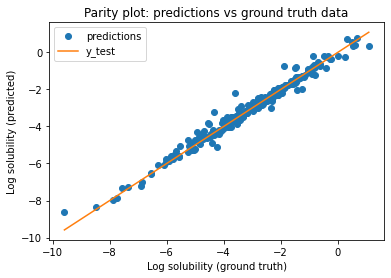

In [47]:
import matplotlib.pyplot as plt
preds = model_xgr.predict(X_test)
x_y_line = np.linspace(min(y_test.flatten()), max(y_test.flatten()), 500)
plt.plot(y_test.flatten(), preds.flatten(), 'o', label='predictions')
plt.plot(x_y_line, x_y_line, label='y_test')
plt.xlabel("Log solubility (ground truth)")
plt.ylabel("Log solubility (predicted)")
plt.title("Parity plot: predictions vs ground truth data")
plt.legend()

In [49]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(64, activation = 'relu', input_dim = 523))

# Adding the second hidden layer
model.add(Dense(units = 64, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 64, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 32, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 16, activation = 'relu'))

# Adding the fourth hidden layer
#model.add(Dense(units = 16, activation = 'relu'))


# Adding the output layer
model.add(Dense(units = 1))

In [50]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [54]:
#model.fit(X_train, y_train, batch_size = 10, epochs = 500)

In [52]:
Y_pred_test_ann = model.predict(X_test)
res = "\n".join("{} {}".format(x, y) for x, y in zip(y_test,Y_pred_test_rf ))
#print(res)

In [53]:
from sklearn.metrics import r2_score
r2_score(y_test, Y_pred_test_ann)

0.9103826016159653

In [55]:
# Save the model
model.save("/content/drive/MyDrive/KIT/solubility_model_91_delney.hdf5")